In [2]:
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy import ndimage, misc
plt.rc('image', cmap='gray')


    Narysować wybrane obrazy.
    Wykorzystać algorytm PCA do kompresji zbioru Olivetti Faces. Dobrać odpowiednią liczbę składowych. Po transformacji obliczyć stopień kompresji. Rozmiar obrazka: liczba wartości numerycznych
    Przeprowadzić transformację odwrotną (inverse_transform). Narysować, porównać z pkt. 0. Obliczyć błąd rekonstrukcji w postaci błędu RMSE dla każdego obrazu.
    Przygotować kilka / kilkanaście zmodyfikowanych obrazów (np. obróconych o 90 stopni, przyciemnionych, odbitych w poziomie).
    Korzystając z modelu wyuczonego w pkt. 1 przeprowadzić transformację, a następnie odwrotną transformację obrazów z pkt. 3. Obliczyć błąd rekonstrukji dla każdego typu modyfikacji. Porównać z wartościami błędu uzyskanymi w pkt. 2.
    Czy PCA może służyć do wykrywania pewnego typu anomalii w zdjęciach twarzy? Jeżeli tak to jakich?


#### Wczytanie danych i wybór twarzy

In [3]:
df = fetch_olivetti_faces()
vec = np.random.randint(0, 400, 12) #wybór losowych twarzy
df = df.images
df = df[vec]

### Przykładowe twarze

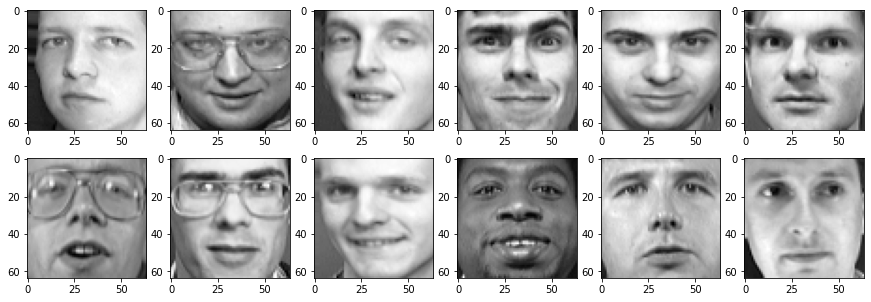

In [4]:
def plot_images(d):
    fig, ax = plt.subplots(2, 6, figsize=(15,5))
    k = 0;
    for i in range(2):
        for j in range(6):
            ax[i,j].imshow(d[k])
            k = k+1
            
plot_images(df)

### Kompresja przy użyciu PCA
na podstawie wykresu procentu wyjaśnionej wariancji

(0.0, 30.0)

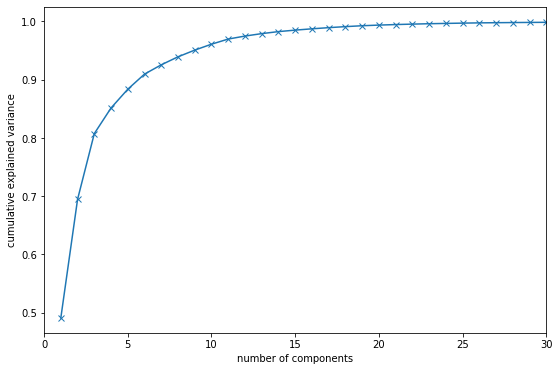

In [5]:
img = df[0]
pca = PCA().fit(img)
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_),marker='x')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.xlim([0, 30])

Optymalny stopień kompresji to 2-4 wymiary.
W dalszej części zadania rozważymy zmniejszenie wymiarowości do 3 wymiarów

#### Obliczenie stopnia kompresji

In [6]:
compression = [0]*3

for i in range(2, 5):
    X_pca_2 = PCA(n_components=i).fit_transform(img)
    compression[i-2] = X_pca_2.size/ img.size
    print(f"Stopień kompresji dla {i} elementów: {compression[i-2]}")

Stopień kompresji dla 2 elementów: 0.03125
Stopień kompresji dla 3 elementów: 0.046875
Stopień kompresji dla 4 elementów: 0.0625


### Transformacja odwrotna

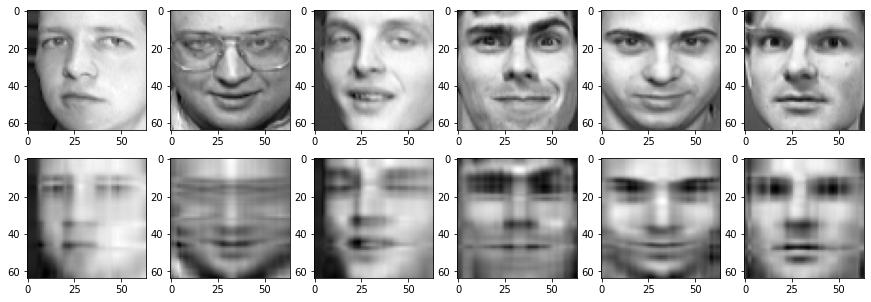

In [7]:
#PCA().fit(img).inverse_transform(img)

#Funkcja wykonuje inverse_transform dla ramki obrazów
def inverse_transform_data(d):
    data = []
    for dfs in d:
        pca = PCA(n_components=3)
        pca.fit(dfs)
        data_reduced = pca.transform(dfs)
        data_original = pca.inverse_transform(data_reduced)
        data.append(data_original)
    return data

inversed_data = inverse_transform_data(df)

# Funkcja porównuje oryginalny obraz oraz obraz przekształcony przy pomocy inverse_transform
def compare_inverse(d, invd):
    fig, ax = plt.subplots(2, 6, figsize=(15,5))
    k = 0   
    t = []
    for j in range(6):
        for i in range(2):
            if i == 0:
                ax[i, j].imshow(d[k])
            else:
                ax[i, j].imshow(invd[k])
        t.append(mean_squared_error(d[k], invd[k]))
        k = k+1
    return t
            
res_rmse = compare_inverse(df, inversed_data)

In [12]:
pd.DataFrame(res_rmse, columns = ['Wartość RMSE-błąd rekonstrukcji obrazu'])

,Wartość RMSE-błąd rekonstrukcji obrazu
0,0.001988
1,0.002834
2,0.001868
3,0.003918
4,0.002460
5,0.002034


### Zmodyfikowane obrazy

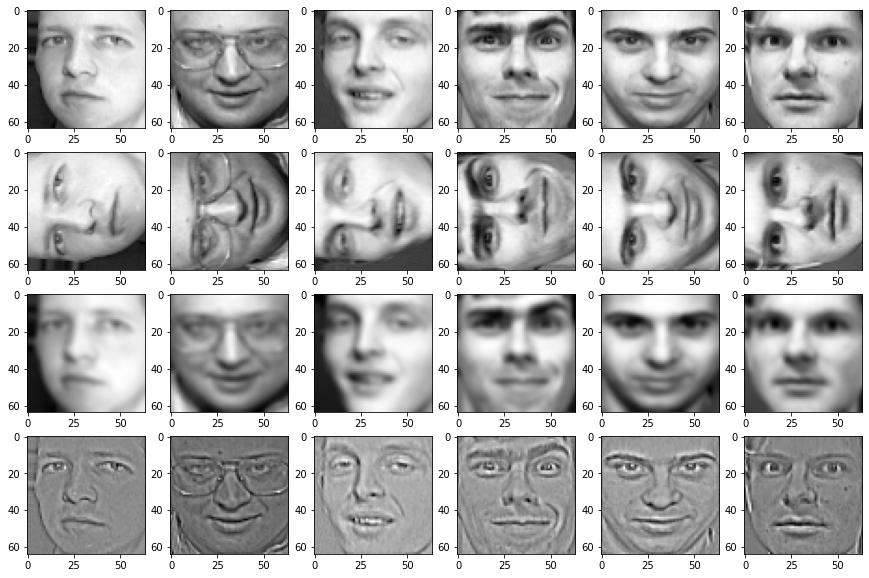

In [9]:
#Funkcja do rysowania przekształconych obrazów(obróconego, rozmytego, rozmytego i ponownie wyostrzonego)
def modified_plots(d, inverse):
    fig, ax = plt.subplots(4, 6, figsize=(15, 10))
    k = 0   
    t = []
    rmse = np.zeros((6, 4))
    for j in range(6):
        for i in range(4):
            base_img = d[k]
            if i == 0:
                modified = base_img
            elif i == 1:
                modified = ndimage.rotate(base_img, 90, reshape=False)
            elif i == 2:
                modified = ndimage.gaussian_filter(base_img, 1.2)
                filtered = modified
            elif i == 3:
                face = misc.face(gray=True).astype(float)
                alpha = 30
                modified = filtered + alpha * (base_img - filtered)
            if inverse == True:
                invm = inverse_transform_data([modified])
                ax[i, j].imshow(invm[0])
                rmse[j, i] = mean_squared_error(modified, invm[0])
            else:
                ax[i, j].imshow(modified)
        k = k+1
    return rmse

a = modified_plots(df, False)

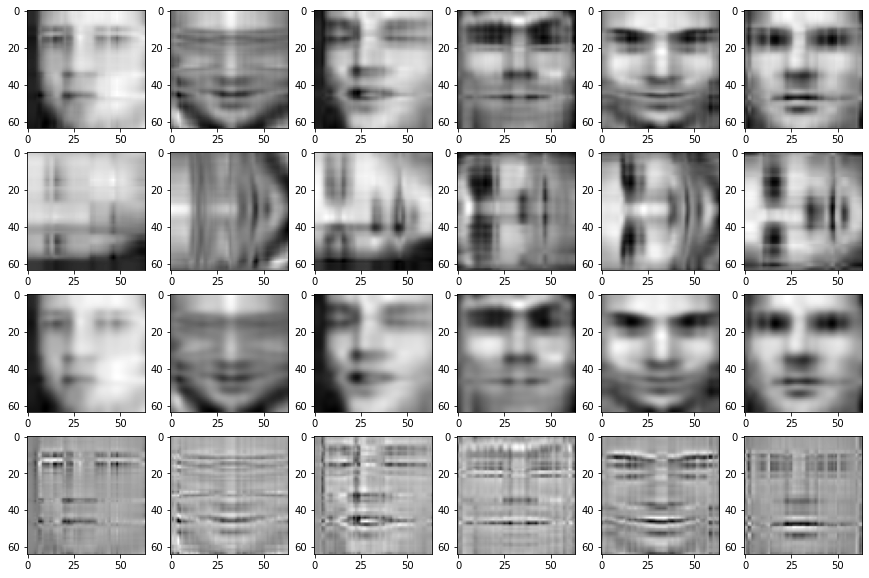

In [10]:
err = modified_plots(inversed_data, True)

In [13]:
pd.DataFrame(err, columns = ['base image', 'rotated', 'blurred', 'blurred+sharpened'])

,base image,rotated,blurred,blurred+sharpened
0,6.350077e-15,0.001054,6.379730e-15,0.016992
1,3.605460e-15,0.000193,4.146260e-15,0.015454
2,5.471318e-15,0.000720,7.044766e-15,0.014296
3,6.142818e-15,0.000799,6.400696e-15,0.026834
4,7.427435e-15,0.000255,7.190104e-15,0.015897
5,7.210649e-15,0.000152,6.791442e-15,0.031481


### Wnioski:
- Algorytm PCA może z powodzeniem służyć do generalizacji algorytmu oraz przyśpieszenia obliczeń.
- PCA może służyć do wykrywania np. nieprawidłowych proporcji twarzy, braku kluczowych elementów, itp.
- Rozmycie obrazu nieznacznie wpłynęło na błąd RMSE, być może jest to związane ze stopniem rozmycia
- Rekonstrukcja obrazu rozmytego, a następnie wyostrzonego jest obarczona największym błędem RMSE